<a href="https://colab.research.google.com/github/taliafabs/sta365-winter2025/blob/main/sta365hw10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STA365 Homework 10
Week 12, April 2, 2024

In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import scipy as stats
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from scipy.special import softmax

## Question 1

Define:
- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

**Gaussian processes**  \\
**Variational inference using the Evidence Lower Bound (ELBO)**

## Question 2

More Gaussian Processes

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

In [39]:
# california housing dataset (good bc it has continuous target)
rng = np.random.default_rng(365)

from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X = data.data
y = data.target

# normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = (y - y.mean()) / y.std()

n = X.shape[0] # num data pts
d = X.shape[1] # num features

# inputs to gp must be arranged as a col vector
X = X[:, np.newaxis, 2]
# # train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

# n = X_train.shape[0]
# d = X_train.shape[1]


In [ ]:
ell_true = 1.0
eta_true = 4.0
cov_func = eta_true**2 * pm.gp.cov.ExpQuad(1, ell_true)
mean_func = pm.gp.mean.Zero()
f_true = pm.draw(pm.MvNormal.dist(mu=mean_func(X), cov=cov_func(X)), 1, random_seed=rng)
sigma_true = 1.0
nu_true = 5.0
y = f_true + sigma_true * rng.standard_t(df=nu_true, size=n)

In [ ]:
# plot data & latent func
## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True generating function 'f'")
ax.plot(X, y, "ok", ms=3, label="Observed data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend(frameon=True);

In [ ]:
with pm.Model() as gp_model:
  ell = pm.Gamma("e")

## Question 3

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.

Resource used: https://www.pymc.io/projects/examples/en/latest/variational_inference/bayesian_neural_network_advi.html


In [14]:
# dataset

# sklearn iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

# normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# make y a one-hot target vector
y = pd.get_dummies(y).to_numpy()

# do the training test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=365)

# define the Bayesian neural network
N = X_train.shape[0] # number of training examples
D = X_train.shape[1] # number of training features
K = y_train.shape[1] # number of classes

<Figure size 800x600 with 0 Axes>

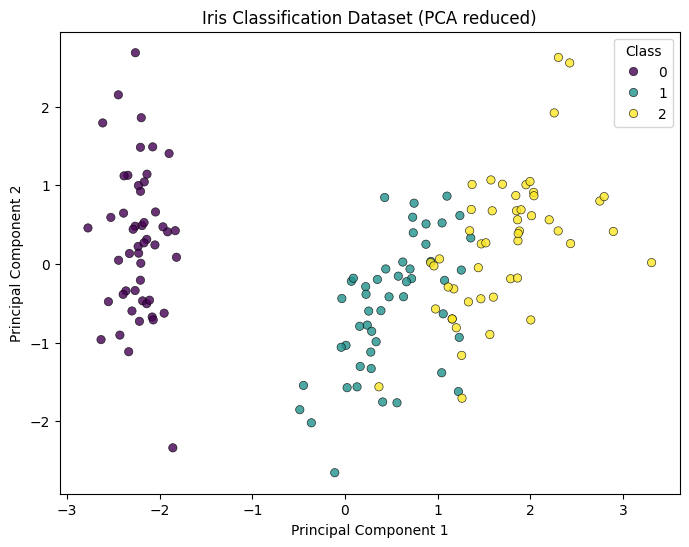

In [12]:
# plotting the features reduced by pca (I learned this in csc311 and sta414)
# use PCA to project onto 1st and 2nd principle components
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df['Target'] = np.argmax(y, axis=1)

plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["PC1"], y=df["PC2"], hue=df["Target"], palette="viridis", alpha=0.8, edgecolor="k")
plt.title("Iris Classification Dataset (PCA reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class")
plt.show()

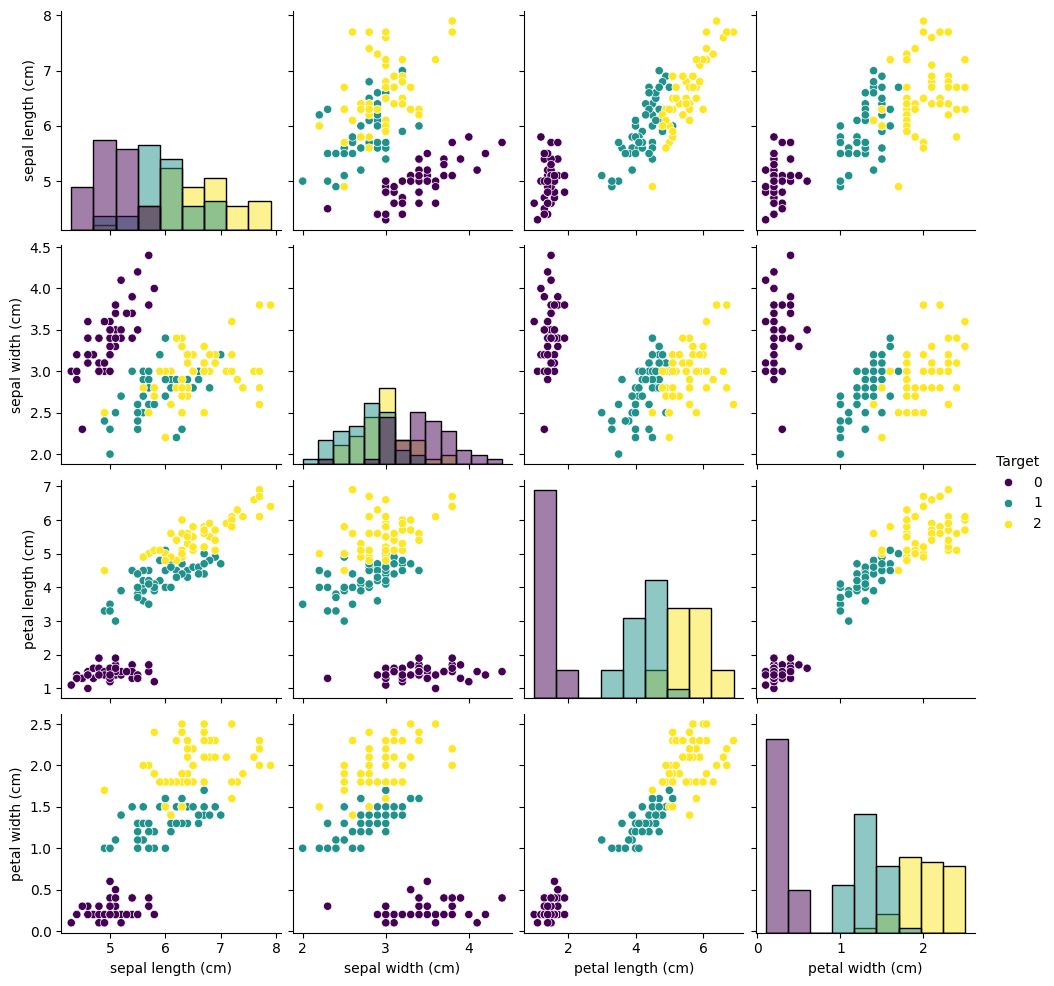

In [16]:
# original features pairplot
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["Target"] = iris.target

sns.pairplot(iris_df, hue="Target", palette="viridis", diag_kind="hist")
plt.show()

In [24]:
with pm.Model() as neural_network:
  # using 1 hidden layer w/ 10 neurons
  # weight and bias priors
  hidden_neurons = 10
  W_in = pm.Normal("W_in", mu=0, sigma=1, shape=(D, hidden_neurons))
  beta_in = pm.Normal("beta_in", mu=0, sigma=1, shape=(hidden_neurons,))
  z1 = pm.math.dot(X_train, W_in) + beta_in
  h1 = pm.math.tanh(z1) # 1st hidden layer
  W_out = pm.Normal('W_out', mu=0, sigma=1, shape=(hidden_neurons, K))
  beta_out = pm.Normal('beta_out', mu=0, sigma=1, shape=(K,))
  z2 = pm.math.dot(h1, W_out) + beta_out # the logits
  class_probs = pm.Deterministic('class_probs', pm.math.softmax(z2, axis=1))
  y_obs = pm.Categorical('y_obs', p=class_probs, observed=np.argmax(y_train, axis=1))
  # VI
  # vi_approx = pm.fit(n=5000, method=pm.ADVI()) # pymc.advi variational inference algorithm
  # ADAM optimizer and smaller learning rate to make ELBO (objective) improve iteratively
  vi_approx = pm.fit(n=10000, method=pm.ADVI(), obj_optimizer=pm.adam(learning_rate=0.005))
  idata_bnn = vi_approx.sample(draws=5000)

Output()

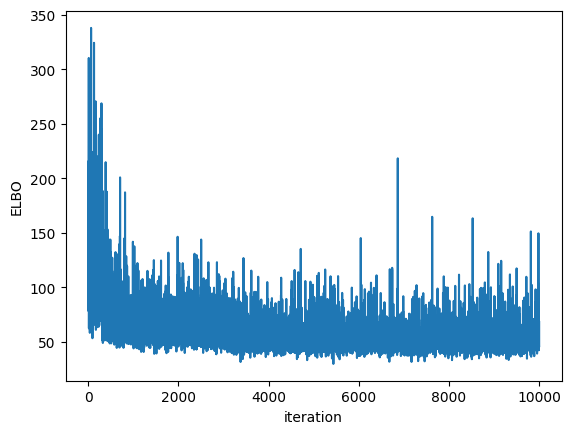

In [26]:
# plot the ELBO to see if/how optimization iteratively improves the fit
plt.plot(vi_approx.hist)
plt.xlabel("iteration number")
plt.ylabel("ELBO (objective)")
plt.show()

In [35]:
# plot posterior predictive
def sample_posterior_predictive(X_test, Y_test, idata, hidden_neurons=10):
    coords = {
        "hidden_layer": np.arange(hidden_neurons),
        "train_cols": np.arange(X_test.shape[1]),
        "obs_id": np.arange(X_test.shape[0]),
    }

    with pm.Model(coords=coords):

        ann_input = X_test
        ann_output = Y_test

        # priors
        W_in = pm.Normal("W_in", mu=0, sigma=1, shape=(X_test.shape[1], hidden_neurons))
        beta_in = pm.Normal("beta_in", mu=0, sigma=1, shape=(hidden_neurons,))

        W_out = pm.Normal("W_out", mu=0, sigma=1, shape=(hidden_neurons, Y_test.shape[1]))
        beta_out = pm.Normal("beta_out", mu=0, sigma=1, shape=(Y_test.shape[1],))

        # perform the forward pass
        z1 = pm.math.dot(ann_input, W_in) + beta_in
        h1 = pm.math.tanh(z1)

        z2 = pm.math.dot(h1, W_out) + beta_out
        class_probs = pm.Deterministic("class_probs", pm.math.softmax(z2, axis=1))

        # categorical likelihood
        out = pm.Categorical("out", p=class_probs, observed=np.argmax(ann_output, axis=1))

        return pm.sample_posterior_predictive(idata, var_names = ['class_probs'])

ppc_bnn = sample_posterior_predictive(X_test, y_test, idata_bnn, hidden_neurons=10)


Output()